In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xarray as xr
import os
import pandas as pd
import scipy.stats
import sys
sys.path.insert(1, '/glade/u/home/lettier/analysis/')
import master_utils as myf

In [3]:
mydir = '/glade/work/lettier/NUDGE/processed/siasivsie/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir))]
mynames = sorted(list(set([f.split('.')[0].split('/')[-1] for f in myfiles])))

In [4]:
listds = []
for name in mynames: 
    if 'OB' not in name:
        subfiles = [mydir+f for f in os.listdir(mydir) if name+'.' in f and f[0]==name[0]]
        ds = xr.open_mfdataset(subfiles)[['sie_nh','sie_sh']]
        ds = ds.set_coords('names')
        listds.append(ds)
ds = xr.concat(listds,dim='names')

In [5]:
oblist = []
for var in ['merged','nt','bt']:
    obds = xr.open_dataset('/glade/work/lettier/CDR/mon/processed/sia_cdr_monthly_processed_nhsh_1979-2018.nc')[['sie_nh_'+var,'sie_sh_'+var]]
    obds = obds.rename({'sie_nh_'+var:'sie_nh','sie_sh_'+var:'sie_sh'})/1e6
    obds['time'] = ds.time
    obds['names'] = 'OBS_'+var
    obds = obds.set_coords('names')
    oblist.append(obds)
obds = xr.concat(oblist,dim='names')

In [6]:
for name in obds.names.values:
    obds.sie_nh.sel(names=name)[9*12-1] = np.nan
    obds.sie_nh.sel(names=name)[9*12] = np.nan

In [7]:
ds = xr.concat([obds, ds], dim='names')

In [9]:
sie_nh = myf.xr_reshape(ds.sie_nh,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)])
sie_sh = myf.xr_reshape(ds.sie_sh,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)])
ds = xr.merge([sie_nh, sie_sh])

In [10]:
thelens = [f for f in ds.names.values if 'LENS' in f]
lensmean = ds.sel(names=thelens).mean(dim='names')
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')

In [11]:
thenudge = ['anom_nudge_era','anom_nudge_era_low','anom_nudge_era_high']
anudgemean = ds.isel(names=0).copy()
for var in ds:
    anudgemean[var] = ds[var].sel(names=thenudge).mean(dim='names')
anudgemean['names'] = 'aNUDGE45mean'
anudgemean = anudgemean.set_coords('names')

In [12]:
thenudge = ['qing_era_6','nudge_era_low','nudge_era_high']
nudgemean = ds.isel(names=0).copy()
for var in ds:
    nudgemean[var] = ds[var].sel(names=thenudge).mean(dim='names')
nudgemean['names'] = 'NUDGEmean'
nudgemean = nudgemean.set_coords('names')

In [13]:
thenudge = ['anom_nudge_era_60','anom_nudge_era_60_archi','anom_nudge_era_60_arclo']
a60nudgemean = ds.isel(names=0).copy()
for var in ds:
    a60nudgemean[var] = ds[var].sel(names=thenudge).mean(dim='names')
a60nudgemean['names'] = 'aNUDGEmean'
a60nudgemean = a60nudgemean.set_coords('names')

In [14]:
#ds = xr.concat([ds,lensmean, nudgemean, anudgemean],dim='names')
ds = xr.concat([ds,lensmean, a60nudgemean, anudgemean, nudgemean],dim='names')

In [15]:
mylist = []
for f in ds.names.values:
    if 'LENS-' in f:
        mylist.append({'label' : 'LENS', 'c' : 'tab:blue', 'linewidth' : .5, 'alpha' : .3})
    elif 'LENSmean' in f:
        mylist.append({'label' : 'LENSmean', 'c' : 'tab:blue', 'linewidth' : 1.5, 'alpha' : 1.})
    elif '60' in f:
        mylist.append({'label' : 'aNUDGE', 'c' : 'tab:red', 'linewidth' : 1.5, 'alpha' : 1.})
    elif 'anom' in f:
        mylist.append({'label' : 'aNUDGE45', 'c' : 'orange', 'linewidth' : 1.5, 'alpha' : 1.})
    elif 'OB' in f:
         mylist.append({'label' : 'NSIDC obs', 'c' : 'k', 'linewidth' : 1.5, 'alpha' : 1.})
            
    elif f=='aNUDGE45mean':
         mylist.append({'label' : 'aNUDGE45mean', 'c' : 'orange', 'linewidth' : 1.5, 'alpha' : 1.})
    elif f=='aNUDGEmean':
        mylist.append({'label' : 'aNUDGEmean', 'c' : 'tab:red', 'linewidth' : 1.5, 'alpha' : 1.})
    elif f=='NUDGEmean':
        mylist.append({'label' : 'NUDGE45mean', 'c' : 'tab:green', 'linewidth' : 1.5, 'alpha' : 1.})
    else:
        mylist.append({'label' : 'NA', 'c' : 'tab:green', 'linewidth' : 1.5, 'alpha' : 1.})
  
df = pd.DataFrame(mylist, index = ds.names.values) 
df = df.transpose()

In [16]:
slope, intercept, r_value, p_value, std_err = myf.linregress(ds.year, ds.load(), dim='year')
detrended = ds - slope*ds.year
annmean = ds.mean(dim='month')
annmean_slope, _, _, _, _ = myf.linregress(ds.year, annmean.load(), dim='year')
annmean_detrended = annmean - annmean_slope*ds.year

In [17]:
for n, name in enumerate(ds.names.values):
    if 'LENSm' in name or 'NUDGEm' in name or 'OBS' in name:
        print(name+' {:.2f}'.format((10.*slope).sel(names=name).sie_nh.sel(month=9).values))


OBS_merged -0.89
OBS_nt -0.86
OBS_bt -0.89
LENSmean -0.65
aNUDGEmean -0.84
NUDGEmean -0.68


In [18]:
(.84-.65)/.84

0.22619047619047614

In [26]:
for n, name in enumerate(ds.names.values):
    if 'LENSm' in name or 'NUDGEm' in name or 'OBS' in name:
        print(name+' {:.2f}'.format(ds.sel(names=name).sie_nh.sel(month=9).sel(year=slice(1979,1996)).mean(dim='year').values))

OBS_merged 7.70
OBS_nt 7.37
OBS_bt 7.69
LENSmean 7.48
aNUDGEmean 7.03
NUDGEmean 7.57


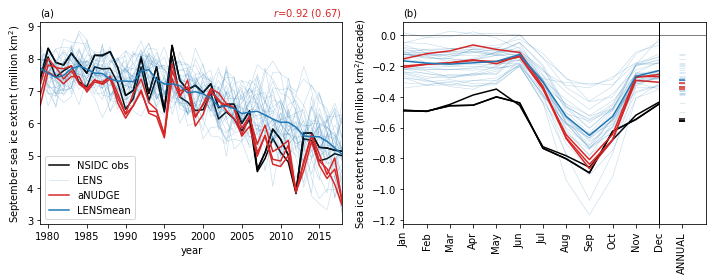

In [58]:
fig = plt.figure(figsize=(10,4))
hemi = 'sie_nh'
mon = 9
ax = plt.subplot(1,2,1)
for n, name in enumerate(ds.names.values):
        if 'LENS' in name or '60' in name or 'OBS' in name:
            ds.sel(names=name)[hemi].sel(month = mon).plot(ax = ax, **df[name].to_dict())     

pearson3, _ = myf.pearson(ds.sel(names='OBS_merged')[hemi].sel(month = mon).load(), ds.sel(names='aNUDGEmean')[hemi].sel(month = mon).load(),dim='year')
pearson3detrended, _ = myf.pearson(detrended.sel(names='OBS_merged')[hemi].sel(month = mon).load(), detrended.sel(names='aNUDGEmean')[hemi].sel(month = mon).load(),dim='year')


ax.set_title('')
ax.set_title('$r$={:0.2f} ({:1.2f})'.format(pearson3.values,pearson3detrended.values),fontsize=10, loc='right', c='tab:red')
ax.set_title('(a)', fontsize=10, loc='left')
ax.set_xlim([1979,2018])
ax.set_ylabel('September sea ice extent (million km$^2$)')
 
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax = plt.subplot(1,2,2)
for n, name in enumerate(ds.names.values):
    if 'LENS' in name or '60' in name or 'OBS' in name:
        (10.*slope).sel(names=name)[hemi].plot(ax = ax, **df[name].to_dict()) 
        ax.scatter(13,10.*annmean_slope.sie_nh.sel(names=name),**df[name].to_dict(), marker='_')
ax.set_title('')
ax.set_title('(b)', fontsize=10, loc='left')
ax.set_xlim([1,14])
ax.set_xticks(np.arange(1,14,1))
ax.set_xticklabels(myf.monthnames+['ANNUAL'], rotation='vertical')
ax.set_xlabel('')
ax.set_ylabel('Sea ice extent trend (million km$^2$/decade)')
ax.set_xlabel('')
ax.axhline(y=0., c='k', linewidth = 0.5)
ax.axvline(x=12,c='k',linewidth=1)


             
plt.tight_layout()
fig.savefig('figs/sie.pdf',dpi=500, bbox_inches='tight')
plt.show(); plt.close()

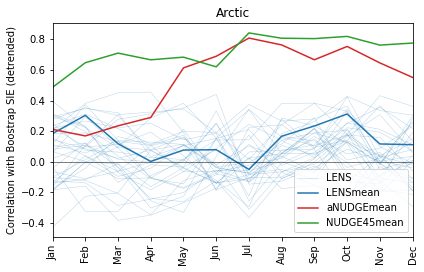

In [60]:
detrended = ds - ds.year*slope
pearson, pval = myf.pearson(detrended.sel(names='OBS_merged'),detrended, dim='year')
fig = plt.figure(figsize=(6,7))
for h, hemi in enumerate(['sie_nh']):
        ax = plt.subplot(2,1,h+1)

        for n, name in enumerate(ds.names.values):
            if ('aNUDGEmean' in name or 'LENS' in name or 'NUDGEmean' in name):
                    pearson.sel(names=name)[hemi].plot(ax = ax, **df[name].to_dict())     
        
        ax.set_title(['Arctic'][h])
        ax.set_xlim([1,12])
        ax.set_xticks(np.arange(1,13,1))
        ax.set_xticklabels(myf.monthnames, rotation='vertical')
        ax.set_xlabel('')
        ax.set_ylabel('Correlation with Boostrap SIE (detrended)')
        ax.axhline(y=0., c='k', linewidth = 0.5)

        if h==0:
            handles, labels = plt.gca().get_legend_handles_labels()
            by_label = dict(zip(labels, handles))
            plt.legend(by_label.values(), by_label.keys(), loc='lower right')
            
plt.tight_layout()
plt.show(); plt.close()

In [61]:
pearson.sel(names='NUDGEmean').sie_nh.values

array([0.48673418, 0.64730678, 0.71018951, 0.66648245, 0.68383875,
       0.62045666, 0.8422994 , 0.80761009, 0.80502642, 0.81957306,
       0.76258283, 0.77604127])

## Now plot SIV

In [62]:
mydir = '/glade/work/lettier/NUDGE/processed/siasivsie/'
myfiles = [mydir+f for f in sorted(os.listdir(mydir))]
mynames = sorted(list(set([f.split('.')[0].split('/')[-1] for f in myfiles])))

In [63]:
# read in PIOMAS
import csv
import pandas as pd
names=[ 'Year',1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]
df = pd.read_csv('/glade/work/lettier/PIOMAS/piomas_v2.1_cp20210119.csv',names=names)
df = df.set_index(['Year'])
da = df.to_xarray()


In [64]:
listsivds = []
for name in mynames: 
    if 'OB' not in name:
        subfiles = [mydir+f for f in os.listdir(mydir) if name+'.' in f and f[0]==name[0]]
        sivds = xr.open_mfdataset(subfiles)[['siv_nh','siv_sh']]
        sivds = sivds.set_coords('names')
        listsivds.append(sivds)
sivds = xr.concat(listsivds,dim='names')
siv_nh = myf.xr_reshape(sivds.siv_nh,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)])
siv_sh = myf.xr_reshape(sivds.siv_sh,'time',['year','month'],[np.arange(1979,2018+1),np.arange(1,13,1)])
sivds = xr.merge([siv_nh, siv_sh])

In [65]:
thelens = [f for f in sivds.names.values if 'LENS' in f]

In [66]:
lensmean = sivds.sel(names=thelens).mean(dim='names')

In [67]:
lensmean['names'] = 'LENSmean'
lensmean = lensmean.set_coords('names')

In [68]:
sivds = xr.concat([sivds,lensmean],dim='names')

In [69]:
mylist = []
for f in sivds.names.values:
    if 'LENSmean' in f:
        mylist.append({'label' : 'LENSmean', 'c' : 'tab:blue', 'linewidth' : 2., 'alpha' : 1.})
 
    elif 'LENS' in f:
        mylist.append({'label' : 'LENS', 'c' : 'tab:blue', 'linewidth' : .5, 'alpha' : .3})
    elif '60' in f:
        mylist.append({'label' : 'aNUDGE', 'c' : 'tab:red', 'linewidth' : 2, 'alpha' : 1.})
    elif 'anom' in f:
        mylist.append({'label' : 'anomNUDGE', 'c' : 'orange', 'linewidth' : 2, 'alpha' : 1.})
    elif 'Boot' in f or 'NASA' in f or 'OSI' in f:
         mylist.append({'label' : 'OBS-'+f, 'c' : 'k', 'linewidth' : 2, 'alpha' : 1.})
    else:
        mylist.append({'label' : 'NUDGE', 'c' : 'tab:green', 'linewidth' : 2, 'alpha' : 1.})
        print(f)
  
df = pd.DataFrame(mylist, index = sivds.names.values) 
df = df.transpose()

nudge_era_MLN_archi
nudge_era_NH
nudge_era_NH_archi
nudge_era_NH_arclo
nudge_era_NH_high
nudge_era_NH_low
nudge_era_SH
nudge_era_archi
nudge_era_arclo
nudge_era_high
nudge_era_low
qing_era_6


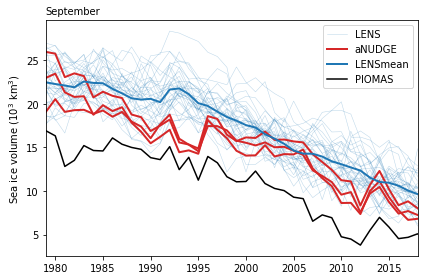

In [70]:
fig = plt.figure(figsize=(6,4))
h = 0
hemi = 'siv_nh'

for m, mon in enumerate([9]):
    ax = plt.subplot(1,1,1)

    for n, name in enumerate(sivds.names.values):
        if 'LENS' in name or '60' in name:
            sivds.sel(names=name)[hemi].sel(month = mon).plot(ax = ax, **df[name].to_dict())     

    ax.set_title('')
    ax.set_title('September',loc='left',fontsize=10)
    ax.set_xlim([1979,2018])
    ax.set_ylabel('Sea ice volume (10$^3$ km$^3$)')
    ax.set_xlabel('')

    if h==0:
        p4, = ax.plot(np.arange(1979,2021,1),da[mon],c='k',label='PIOMAS')


    if h==0 and m==0:
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys())


plt.tight_layout()
fig.savefig('figs/siv.pdf',dpi=500, bbox_inches='tight')
plt.show(); plt.close()

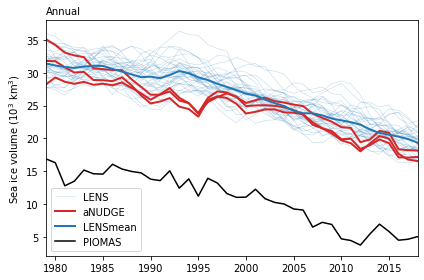

In [71]:
fig = plt.figure(figsize=(6,4))
h = 0
hemi = 'siv_nh'

ax = plt.subplot(1,1,1)

for n, name in enumerate(sivds.names.values):
    if 'LENS' in name or '60' in name:
        sivds.sel(names=name)[hemi].mean(dim='month').plot(ax = ax, **df[name].to_dict())     

ax.set_title('')
ax.set_title('Annual',loc='left',fontsize=10)
ax.set_xlim([1979,2018])
ax.set_ylabel('Sea ice volume (10$^3$ km$^3$)')
ax.set_xlabel('')

if h==0:
    p4, = ax.plot(np.arange(1979,2021,1),da[mon],c='k',label='PIOMAS')


if h==0 and m==0:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())


plt.tight_layout()
plt.show(); plt.close()

In [72]:
sivds.isel(month=0).isel(year=0).sel(names=[f for f in sivds.names.values if '60' in f]).siv_nh.values

array([34.18882 , 38.24881 , 29.970362], dtype=float32)

In [73]:
38.24881-29.970362

8.278447999999997

In [74]:
mylist = []
for f in ds.names.values:
    if 'LENS-' in f:
        mylist.append({'label' : 'LENS', 'c' : 'tab:blue', 'linewidth' : .5, 'alpha' : .3})
    elif 'LENSmean' in f:
        mylist.append({'label' : 'LENSmean', 'c' : 'tab:blue', 'linewidth' : 1, 'alpha' : 1.})
    elif '60' in f:
        mylist.append({'label' : 'aNUDGE', 'c' : 'tab:red', 'linewidth' : 1, 'alpha' : 1.})
    elif 'anom' in f:
        mylist.append({'label' : 'aNUDGE45', 'c' : 'orange', 'linewidth' : 1, 'alpha' : 1.})
    elif 'OB' in f:
         mylist.append({'label' : 'NSIDC CDR', 'c' : 'k', 'linewidth' : 1.5, 'alpha' : 1.})
            
    elif f=='aNUDGE45mean':
         mylist.append({'label' : 'aNUDGE45mean', 'c' : 'orange', 'linewidth' : 1.5, 'alpha' : 1.})
    elif f=='aNUDGEmean':
        mylist.append({'label' : 'aNUDGEmean', 'c' : 'tab:red', 'linewidth' : 1.5, 'alpha' : 1.})
    elif f=='NUDGEmean':
        mylist.append({'label' : 'NUDGE45mean', 'c' : 'tab:green', 'linewidth' : 1.5, 'alpha' : 1.})
    else:
        mylist.append({'label' : 'NA', 'c' : 'tab:green', 'linewidth' : 1.5, 'alpha' : 1.})
  
df = pd.DataFrame(mylist, index = ds.names.values) 
df = df.transpose()

In [75]:
mytime = pd.date_range(start="1979-01-01",end="2018-12-31", freq='M')

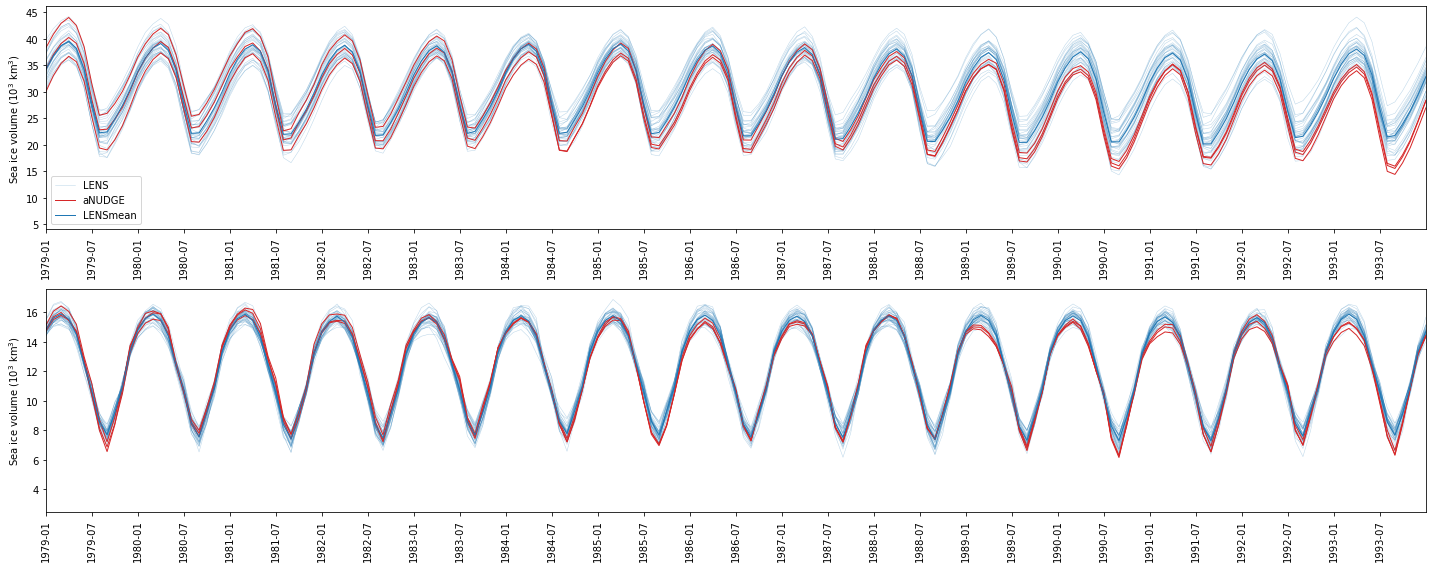

In [76]:
fig = plt.figure(figsize=(20,8))
ax = plt.subplot(2,1,1)
for n, name in enumerate(ds.names.values):
    if 'LENS' in name or '60' in name:
        mydata = sivds.sel(names=name).siv_nh.values.flatten()
        ax.plot(np.arange(len(mydata)), mydata, **df[name].to_dict())     

ax.set_xlim([0,180])
ax.set_xticks(np.arange(0,180,6))
ax.set_xticklabels([str(f)[:7] for f in mytime[:180][::6]],rotation='vertical')
ax.set_ylabel('Sea ice volume (10$^3$ km$^3$)')

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())


ax = plt.subplot(2,1,2)
for n, name in enumerate(ds.names.values):
    if 'LENS' in name or '60' in name:
        mydata = ds.sel(names=name).sie_nh.values.flatten()
        ax.plot(np.arange(len(mydata)), mydata, **df[name].to_dict())     

ax.set_xlim([0,180])
ax.set_xticks(np.arange(0,180,6))
ax.set_xticklabels([str(f)[:7] for f in mytime[:180][::6]],rotation='vertical')
ax.set_ylabel('Sea ice volume (10$^3$ km$^3$)')


plt.tight_layout()
#fig.savefig('figs/allnudge_siv_nhsh_timeseries_1979-2018.png', bbox_inches='tight')
plt.show(); plt.close()

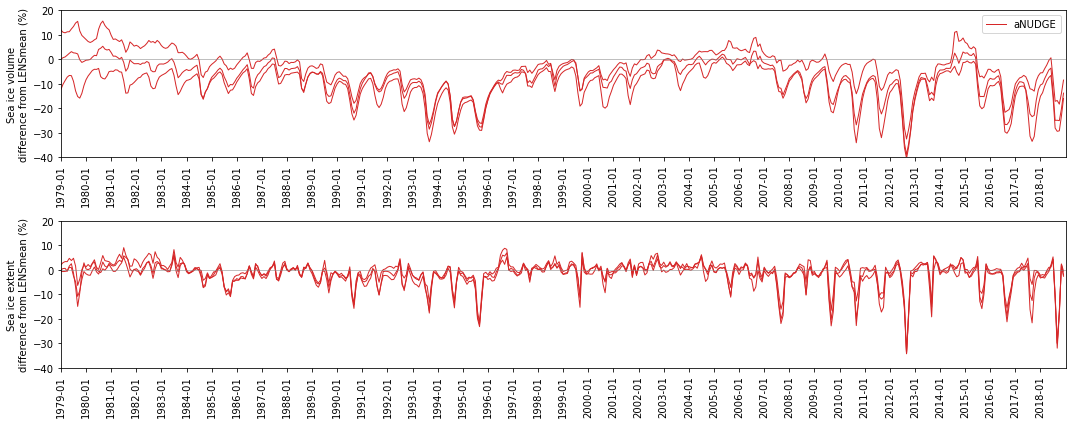

In [95]:
fig = plt.figure(figsize=(15,6))
ax = plt.subplot(2,1,1)
for n, name in enumerate(ds.names.values):
    if '60' in name:
        mydata = 100.*((sivds.sel(names=name)-sivds.sel(names='LENSmean'))/sivds.sel(names='LENSmean')).siv_nh.values.flatten()
        ax.plot(np.arange(len(mydata)), mydata, **df[name].to_dict())     
ax.axhline(y=0,c='grey',linewidth=.5)
ax.set_xticks(np.arange(480)[::12])
ax.set_xticklabels([str(f)[:7] for f in mytime[::12]],rotation='vertical')
ax.set_ylabel('Sea ice volume\ndifference from LENSmean (%)')
ax.set_ylim([-40,20])
ax.set_xlim([0,480])

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

ax = plt.subplot(2,1,2)
for n, name in enumerate(ds.names.values):
    if '60' in name:
        mydata = 100.*((ds.sel(names=name)-ds.sel(names='LENSmean'))/ds.sel(names='LENSmean')).sie_nh.values.flatten()
        ax.plot(np.arange(len(mydata)), mydata, **df[name].to_dict())     
ax.axhline(y=0,c='grey',linewidth=.5)
ax.set_xticks(np.arange(480)[::12])
ax.set_xticklabels([str(f)[:7] for f in mytime[::12]],rotation='vertical')
ax.set_ylabel('Sea ice extent\ndifference from LENSmean (%)')
ax.set_ylim([-40,20])
ax.set_xlim([0,480])

plt.tight_layout()
fig.savefig('figs/aNUDGEminusLENSmean_siesiv.pdf', bbox_inches='tight')
plt.show(); plt.close()

In [87]:
ds= xr.merge([ds, sivds])

In [88]:

trend_1979to2018, intercept, r_value, p_value_1979to2018, std_err = myf.linregress(ds.year, ds.load(), dim='year')
trend_1979to1998, intercept, r_value, p_value_1979to1998, std_err = myf.linregress(ds.year.isel(year=slice(0,20)), ds.isel(year=slice(0,20)), dim='year')
trend_1999to2018, intercept, r_value, p_value_1999to2018, std_err = myf.linregress(ds.year.isel(year=slice(20,None)), ds.isel(year=slice(20,None)), dim='year')


In [100]:
[f for f in ds.names.values if '60' in f]

['anom_nudge_era_60', 'anom_nudge_era_60_archi', 'anom_nudge_era_60_arclo']

In [102]:
for var in ['sie_nh','siv_nh']:

    print('trend in '+var+' in anudge60 (mean)')
    
    print('1979-2018: {:.4f} 10^6 km^2/year, p={:3f}'.format(trend_1979to2018[var].sel(month=9).sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values,
                                                    100.*p_value_1979to2018[var].sel(month=9).sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values))

    print('1979-1998: {:.4f} 10^6 km^2/year, p={:3f}'.format(trend_1979to1998[var].sel(month=9).sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values,
                                                    100.*p_value_1979to1998[var].sel(month=9).sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values))

    print('1999-2018: {:.4f} 10^6 km^2/year, p={:3f}'.format(trend_1999to2018[var].sel(month=9).sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values,
                                                    100.*p_value_1999to2018[var].sel(month=9).sel(names=[f for f in ds.names.values if '60' in f]).mean(dim='names').values))

trend in sie_nh in anudge60 (only one run so far)
1979-2018: -0.0838 10^6 km^2/year, p=0.000000
1979-1998: -0.0463 10^6 km^2/year, p=5.363358
1999-2018: -0.1433 10^6 km^2/year, p=0.000144
trend in siv_nh in anudge60 (only one run so far)
1979-2018: -0.3561 10^6 km^2/year, p=0.000000
1979-1998: -0.3668 10^6 km^2/year, p=0.002895
1999-2018: -0.4830 10^6 km^2/year, p=0.000002


In [103]:
print('sie_nh trend in obs')
var = 'sie_nh'

print('1979-2018: {:.4f} 10^6 km^2/year, p={:3f}'.format(trend_1979to2018[var].sel(names='OBS_merged').sel(month=9).values,
                                                100.*p_value_1979to2018[var].sel(names='OBS_merged').sel(month=9).values))

print('1979-1998: {:.4f} 10^6 km^2/year, p={:3f}'.format(trend_1979to1998[var].sel(names='OBS_merged').sel(month=9).values,
                                                100.*p_value_1979to1998[var].sel(names='OBS_merged').sel(month=9).values))

print('1999-2018: {:.4f} 10^6 km^2/year, p={:3f}'.format(trend_1999to2018[var].sel(names='OBS_merged').sel(month=9).values,
                                                100.*p_value_1999to2018[var].sel(names='OBS_merged').sel(month=9).values))

sie_nh trend in obs
1979-2018: -0.0895 10^6 km^2/year, p=0.000000
1979-1998: -0.0398 10^6 km^2/year, p=6.542361
1999-2018: -0.1137 10^6 km^2/year, p=0.013604
